# Introduction

Here're several notebooks that really give me great inspiration. I really recommend you to take a look!

## Problem description
In this competition, we want to build a model to make prediction on the total ride duration of taxi trips in New York City.<br>
Data fields:
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## Observation
After scanning through the data fields, we can know that we have to deal with not only categorical and numerical data, but also time series and location data. And we may want to eliminate store_and_fwd_flag since it doesn't look like a feature that will contribute to the prediction.
We'll deal with the data step by step.
Before we go any further, let's import some packages that we're going to use later.

In [119]:
%matplotlib inline
from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import timedelta
import datetime as dt
import operator
import time
import folium
import gpxpy.geo
from scipy.stats import skew
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
sns.set()

Loading BokehJS ...

In [62]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [63]:
print("There are", train.shape[1], "features and", train.shape[0], "samples in training data.")
print("There are", test.shape[1], "features and", test.shape[0], "samples in training data.")

There are 11 features and 1458644 samples in training data.
There are 9 features and 625134 samples in training data.


In [64]:
print("Features in training data:")
print(train.columns)
print("Feature in testing data:")
print(test.columns)

Features in training data:
Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')
Feature in testing data:
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


We can see above that, in testing data, we don't have dropoff_datatime and trip_duration. This makes sense since these are the feature that we're going to predict.

Let's take a look at what training data looks like.

In [65]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


We also curious about if there's missing value or not.

In [67]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


Great! We don't have to deal with missing value!

It seems that the region of training and testing dataset are overlapped.

(40.63, 40.85)

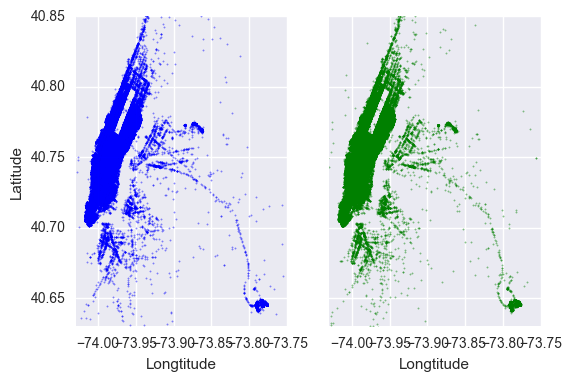

In [68]:
N = 100000
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
ax[0].scatter(train["pickup_longitude"].values[:N], train["pickup_latitude"].values[:N], s=1, color='b', alpha=0.4)
ax[0].set_xlabel("Longtitude")
ax[0].set_ylabel("Latitude")
ax[1].scatter(test["pickup_longitude"].values[:N], test["pickup_latitude"].values[:N], s=1, color='g', alpha=0.4)
ax[1].set_xlabel("Longtitude")
plt.xlim(city_long_border)
plt.ylim(city_lat_border)

In [69]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

In [86]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour

test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour'] = test['pickup_datetime'].dt.hour

In [109]:
def traffic_counts(groupby, xlabel, xlim):
    if xlim != 'None':
        plt.xlim(xlim)
    pickup_c = [train.groupby(groupby).count()['id'], test.groupby(groupby).count()['id']]
    plt.xlabel(xlabel)
    plt.ylabel('traffic counts')
    plt.plot(pickup_c[0], 'o-', label='train')
    plt.plot(pickup_c[1], 'o-', label='test')
    plt.legend(loc='upper left')

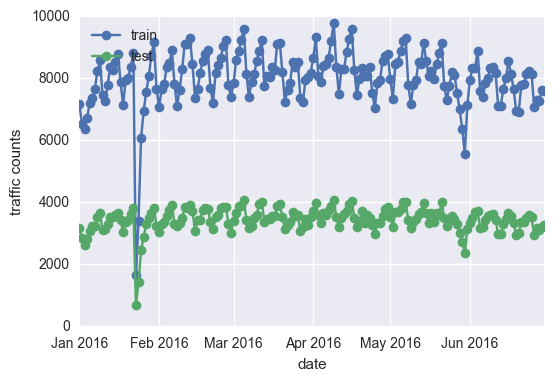

In [110]:
traffic_counts('pickup_date', 'date', 'None')

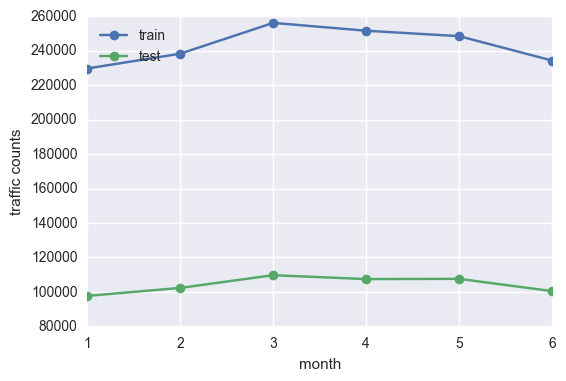

In [111]:
traffic_counts('pickup_month', 'month', 'None')

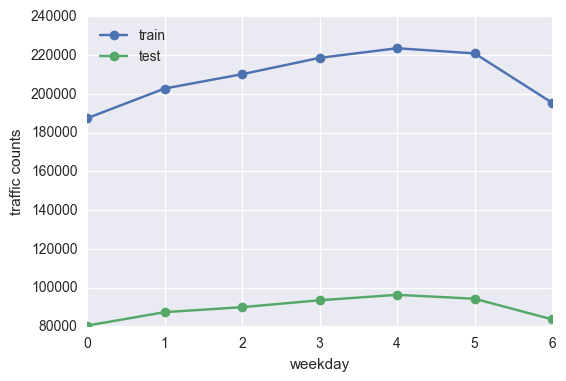

In [112]:
traffic_counts('pickup_weekday', 'weekday', (0, 6))

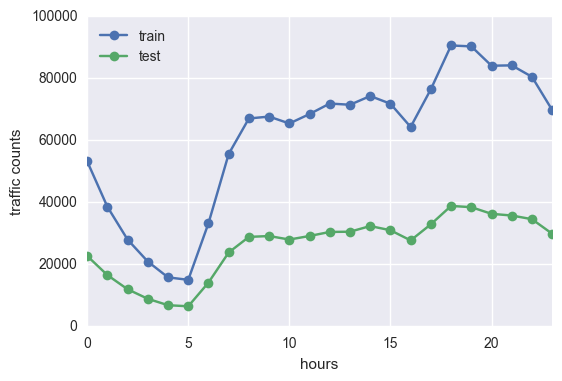

In [113]:
traffic_counts('pickup_hour', 'hours', (0, 23))

In [14]:
min_pickup_hour, _ = min(enumerate(pickup_hour_c[0]), key=operator.itemgetter(1))
max_pickup_hour, _ = max(enumerate(pickup_hour_c[0]), key=operator.itemgetter(1))
print("Least people take a taxi at", min_pickup_hour, "o'clock.")
print("Most people take a taxi at", max_pickup_hour, "o'clock.")

Least people take a taxi at 5 o'clock.
Most people take a taxi at 18 o'clock.


In [15]:
train['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

The origin haversine library does not work well with numpy array. Thus we custom one by ourselves using numpy.

In [130]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

In [131]:
train['distance'] = haversine_(train['pickup_latitude'].values, train['pickup_longitude'].values,
                              train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test['distance'] = haversine_(test['pickup_latitude'].values, test['pickup_longitude'].values,
                             test['dropoff_latitude'].values, test['dropoff_longitude'].values)

Let's inspect the data using vendor_id.

In [190]:
count_vendor = train.groupby('vendor_id')['id'].count()
print("vendor_id 1 has", count_vendor.get(1), "data, while vendor_id 2 has", count_vendor.get(2), "data.")

vendor_id 1 has 678342 data, while vendor_id 2 has 780302 data.


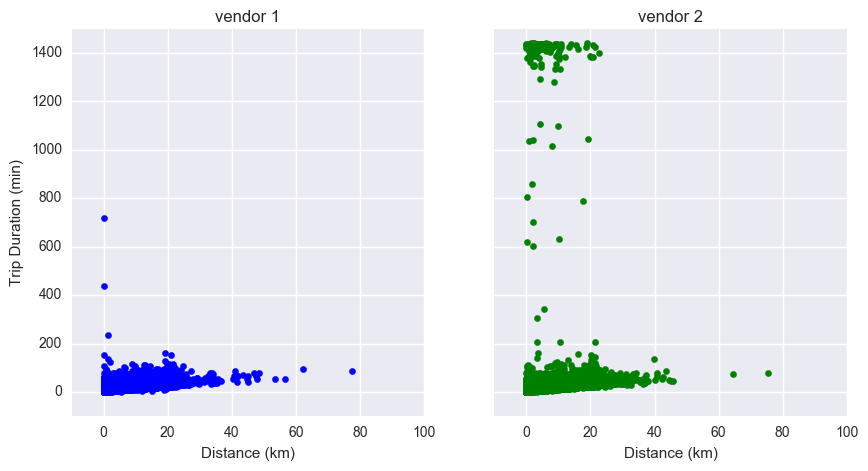

In [241]:
N = 100000
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
vendor_1 = train[train['vendor_id']==1]
vendor_2 = train[train['vendor_id']==2]
ax[0].set_title("vendor 1")
ax[0].set_xlim(-10, 100)
ax[0].set_ylim(-100, 1500)
ax[0].set_xlabel("Distance (km)")
ax[0].set_ylabel("Trip Duration (min)")
ax[1].set_title("vendor 2")
ax[1].set_xlabel("Distance (km)")
ax[0].scatter(vendor_1['distance'][:N], vendor_1['trip_duration'][:N]/60, color='blue')
ax[1].scatter(vendor_2['distance'][:N], vendor_2['trip_duration'][:N]/60, color='green')

In [256]:
# 1200 min = 1200/60 -> 20hr
vendor_2[vendor_2['trip_duration']/60 > 1200]['id'].count()

1929

It seems that taxi with vendor id 2 drive passengers further but with raletively short distance. That's quit strange! We assume these data are outliers.

Check the speed!

In [260]:
# compute speed in minutes
train['speed'] = train['distance'] / (train['trip_duration']/60)

In [261]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_month', 'pickup_week',
       'pickup_hour', 'pickup_day', 'pickup_weekday', 'distance',
       'log_trip_duration', 'speed'],
      dtype='object')

Speed in some extends represents traffic flow. The slower the speed is, the heavier the traffic is.

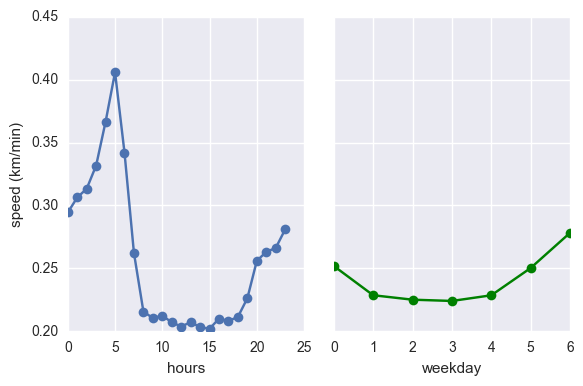

In [271]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].set_xlabel("hours")
ax[0].set_ylabel("speed (km/min)")
ax[1].set_xlabel("weekday")
ax[0].plot(train.groupby('pickup_hour')['speed'].mean(), 'o-')
ax[1].plot(train.groupby('pickup_weekday')['speed'].mean(), 'o-', color='green')
plt.tight_layout()

We can observe that in rush hours (around 7 ~ 19 o'clock), the traffic is way heavier than early morning.
While on Friday and weekend, the traffic is ralatively light.

The origin value in 'store_and_fwd_flag' is Y & N.

In [327]:
print("In training file:")
print(train['store_and_fwd_flag'].value_counts())
print("In testing file:")
print(test['store_and_fwd_flag'].value_counts())

In training file:
0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64
In testing file:
N    621704
Y      3430
Name: store_and_fwd_flag, dtype: int64


Here, we convert Y to 1 and N to 0.

In [329]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({"Y": 1, "N":0})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace({"Y": 1, "N":0})

Let's check if 'store_and_fwd_flag' has any relationship with vendor_id.

In [330]:
print("In training file:")
print(train.groupby('vendor_id')['store_and_fwd_flag'].sum())
print("In testing file:")
print(test.groupby('vendor_id')['store_and_fwd_flag'].sum())

In training file:
vendor_id
1    8045
2       0
Name: store_and_fwd_flag, dtype: int64
In testing file:
vendor_id
1    3430
2       0
Name: store_and_fwd_flag, dtype: int64


It seems that in both training and testing file, only vendor_id 1 has store_and_fwd_flag!
This also means that we can safely delete this feature, since it can be represented by the vendor_id.

In [332]:
train.drop('store_and_fwd_flag', axis=1, inplace=True)
test.drop('store_and_fwd_flag', axis=1, inplace=True)

In [286]:
from sklearn.cluster import MiniBatchKMeans

In [287]:
longtitude = train['pickup_longitude'].tolist() + train['dropoff_longitude'].tolist()
latitude = train['pickup_latitude'].tolist() + train['dropoff_latitude'].tolist()
location_df = pd.DataFrame({"longtitude":longtitude, "latitude":latitude})

In [288]:
n_clusters = 10
start = time.time()
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=2)
kmeans.fit(location_df)
end = time.time()
print("It takes", (end-start), "seconds to train a MiniBatchKMeans.")

It takes 5.046754837036133 seconds to train a MiniBatchKMeans.


In [289]:
location_df['labels'] = kmeans.labels_

In [302]:
location_df.head()

,latitude,longtitude,labels
0,40.767937,-73.982155,6
1,40.738564,-73.980415,7
2,40.763939,-73.979027,3
3,40.719971,-74.010040,0
4,40.793209,-73.973053,6


(40.63, 40.85)

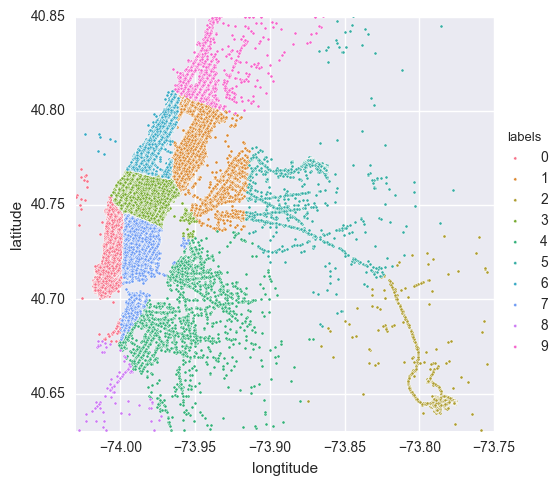

In [290]:
N = 300000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
sns.pairplot(x_vars=['longtitude'], y_vars=['latitude'], data=location_df.loc[:N,:],
             hue='labels', size=5, aspect=1, plot_kws={"s": 5})
plt.xlim(city_long_border)
plt.ylim(city_lat_border)

In [291]:
kmeans.cluster_centers_[1, 0]

40.775798316623856

In [299]:
train_pickup = pd.concat((train['pickup_latitude'], train['pickup_longitude']), axis=1)
train_drop = pd.concat((train['dropoff_latitude'], train['dropoff_longitude']), axis=1)
test_pickup = pd.concat((test['pickup_latitude'], test['pickup_longitude']), axis=1)
test_drop = pd.concat((test['dropoff_latitude'], test['dropoff_longitude']), axis=1)
train_plabels = kmeans.predict(train_pickup)
train_dlabels = kmeans.predict(train_drop)
test_plabels = kmeans.predict(test_pickup)
test_dlabels = kmeans.predict(test_drop)

In [304]:
train['plabels'] = train_plabels 
train['dlabels'] = train_dlabels
test['plabels'] = test_plabels
test['dlabels'] = test_dlabels

In [305]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_week,pickup_hour,pickup_day,pickup_weekday,distance,log_trip_duration,speed,plabels,dlabels
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,3,11,17,0,0,1.498521,6.122493,0.197607,6,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,23,0,6,6,1.805507,6.498282,0.163394,7,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,1,3,11,1,1,6.385098,7.661527,0.180370,3,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4,14,19,2,2,1.485498,6.063785,0.207762,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,3,12,13,5,5,1.188588,6.077642,0.163943,6,6


In [57]:
# map_osm = folium.Map(location=[40.78, -73.85], zoom_start=12)
# map_osm

Skewness: 343.163590698184


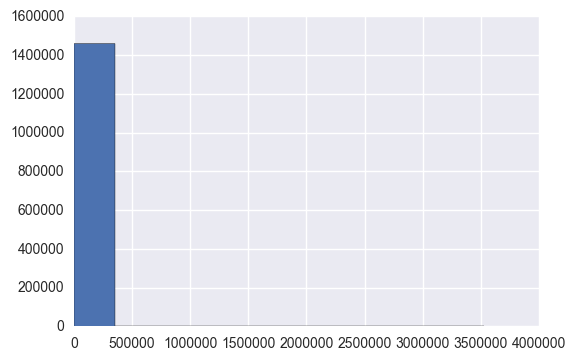

In [142]:
print("Skewness:", skew(train['trip_duration']))
_ = plt.hist(train['trip_duration'])

Since trip_duration is severely right skewed, we do log transform here.

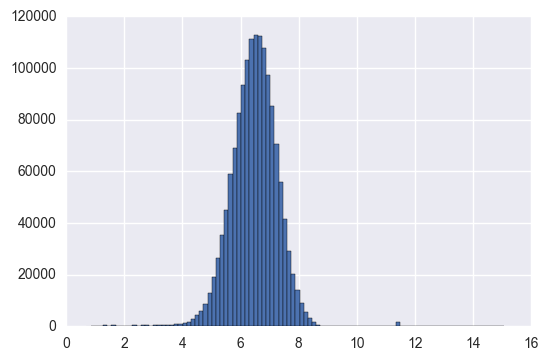

In [145]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])
_ = plt.hist(train['log_trip_duration'], bins=100)

---

In [258]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBRegressor()
